In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Generator model for time-series data
def build_generator():
    model = keras.Sequential([
        layers.Input(shape=(30, 1)),
        layers.LSTM(100, return_sequences=True),
        layers.LSTM(50),
        layers.Dense(30, activation='linear'),
        layers.Reshape((30, 1))
    ])
    return model

# Discriminator model for time-series data
def build_discriminator():
    model = keras.Sequential([
        layers.Input(shape=(30, 1)),
        layers.LSTM(50, return_sequences=True),
        layers.LSTM(50),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create and compile the GAN
class GAN(keras.Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = build_generator()
        self.discriminator = build_discriminator()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]

        # Generate noise
        noise = tf.random.normal(shape=(batch_size, 30, 1))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake data
            generated_data = self.generator(noise, training=True)

            # Get discriminator decisions
            real_output = self.discriminator(real_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)

            # Calculate losses
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
            real_loss = self.loss_fn(tf.ones_like(real_output), real_output)
            fake_loss = self.loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = (real_loss + fake_loss) / 2

        # Calculate gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))

        return {"d_loss": disc_loss, "g_loss": gen_loss}

# Generate synthetic retail sales data
def generate_real_data(n_samples):
    X = np.linspace(0, 100, n_samples * 30).reshape(n_samples, 30, 1)
    y = np.sin(X) + np.random.normal(scale=0.5, size=X.shape)
    return y

# Create and compile the GAN
gan = GAN()
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002),
    loss_fn=keras.losses.BinaryCrossentropy()
)

# Training
EPOCHS = 1000
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    # Generate real data
    real_data = generate_real_data(BATCH_SIZE)

    # Train step
    losses = gan.train_step(real_data)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}")
        print(f"D loss: {losses['d_loss']:.4f}")
        print(f"G loss: {losses['g_loss']:.4f}")

Epoch 0
D loss: 0.6940
G loss: 0.6931
Epoch 100
D loss: 0.4423
G loss: 1.4586
Epoch 200
D loss: 0.5583
G loss: 0.7274
Epoch 300
D loss: 0.2961
G loss: 1.7351
Epoch 400
D loss: 0.1671
G loss: 2.6890
Epoch 500
D loss: 0.0567
G loss: 2.3903
Epoch 600
D loss: 0.5904
G loss: 1.4029
Epoch 700
D loss: 0.0943
G loss: 2.3644
Epoch 800
D loss: 0.6587
G loss: 2.4613
Epoch 900
D loss: 0.5267
G loss: 1.5596


In [2]:
from tensorflow.keras import backend as K

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, input_shape, latent_dim):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_encoder(self):
        encoder_inputs = keras.Input(shape=self.input_shape)
        x = layers.LSTM(50, return_sequences=True)(encoder_inputs)
        x = layers.LSTM(50)(x)
        z_mean = layers.Dense(self.latent_dim)(x)
        z_log_var = layers.Dense(self.latent_dim)(x)
        return keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

    def build_decoder(self):
        decoder_inputs = keras.Input(shape=(self.latent_dim,))
        x = layers.Dense(50)(decoder_inputs)
        x = layers.RepeatVector(self.input_shape[0])(x)
        x = layers.LSTM(50, return_sequences=True)(x)
        decoder_outputs = layers.TimeDistributed(layers.Dense(self.input_shape[1]))(x)
        return keras.Model(decoder_inputs, decoder_outputs, name="decoder")

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = Sampling()([z_mean, z_log_var])
            reconstruction = self.decoder(z)

            # Compute losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(data - reconstruction),  # MSE calculation
                    axis=[1, 2]
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()([z_mean, z_log_var])
        reconstruction = self.decoder(z)
        return reconstruction

# Create and compile the VAE
input_shape = (30, 1)
latent_dim = 10

vae = VAE(input_shape, latent_dim)
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE using the same data generation function from before
train_data = generate_real_data(1000)
history = vae.fit(train_data, epochs=50, batch_size=32)

# Generate new samples
latent_samples = tf.random.normal(shape=(10, latent_dim))
generated_samples = vae.decoder(latent_samples)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - kl_loss: 0.4352 - loss: 22.1182 - reconstruction_loss: 21.6831
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - kl_loss: 1.9333 - loss: 12.8672 - reconstruction_loss: 10.9339
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - kl_loss: 2.0848 - loss: 12.3892 - reconstruction_loss: 10.3043
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - kl_loss: 1.9411 - loss: 11.7395 - reconstruction_loss: 9.7984
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - kl_loss: 1.8958 - loss: 10.9976 - reconstruction_loss: 9.1018
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - kl_loss: 1.8332 - loss: 10.2287 - reconstruction_loss: 8.3955
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - kl_loss: 1.6945 - loss: 10.1684 - reconstruction_loss: 8.4739
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - kl_loss: 1.7057 - loss: 9.8886 - reconstruction_loss: 8.1829
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - kl_loss: 1.6952 - loss: 

## Visualize the results after training

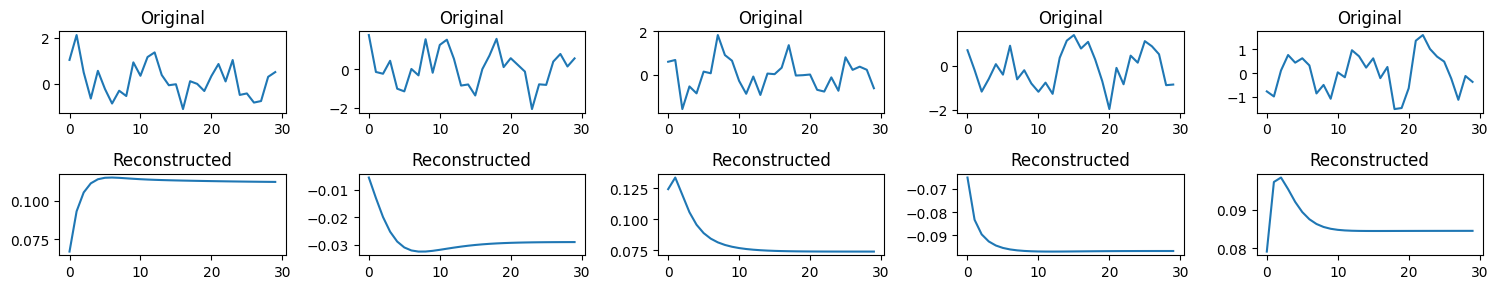

In [3]:
import matplotlib.pyplot as plt

# Plot original vs reconstructed data
n_samples = 5
test_data = generate_real_data(n_samples)
reconstructed_data = vae(test_data)

plt.figure(figsize=(15, 3))
for i in range(n_samples):
    # Original
    plt.subplot(2, n_samples, i + 1)
    plt.plot(test_data[i, :, 0])
    plt.title('Original')

    # Reconstructed
    plt.subplot(2, n_samples, n_samples + i + 1)
    plt.plot(reconstructed_data[i, :, 0])
    plt.title('Reconstructed')

plt.tight_layout()
plt.show()

In [20]:
# Cell 1: Imports and Setup
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Cell 2: ARIMA Implementation (fixed)
def fit_arima(data, order=(5,1,0)):
    # Flatten and fit ARIMA
    flat_data = data.flatten()
    model = sm.tsa.ARIMA(flat_data, order=order)
    fitted_model = model.fit()

    # Generate predictions
    preds = fitted_model.predict(start=0, end=len(flat_data)-1)
    # Reshape to match original shape
    return preds.reshape(-1, 30, 1)  # Removed .values

In [6]:
# Cell 3: Rule-Based System (unchanged)
def generate_rule_based_data(n_samples):
    X = np.linspace(0, 100, n_samples * 30).reshape(n_samples, 30, 1)
    # Combine sine wave with trend and seasonality
    trend = 0.1 * X
    seasonality = np.sin(2 * np.pi * X / 12)
    noise = 0.1 * np.random.randn(*X.shape)
    y = trend + seasonality + noise
    return y

In [7]:
# Cell 4: Generate Data from All Methods
# Generate samples from each method
n_samples = 100

# Real data
real_data = generate_real_data(n_samples)

try:
    # ARIMA predictions
    arima_data = fit_arima(real_data)
except Exception as e:
    print(f"ARIMA failed: {e}")
    # Fallback to simple AR process if ARIMA fails
    arima_data = np.zeros_like(real_data)
    for i in range(n_samples):
        ar_process = np.random.randn(30, 1)
        for t in range(1, 30):
            ar_process[t] = 0.8 * ar_process[t-1] + 0.2 * np.random.randn()
        arima_data[i] = ar_process

# Rule-based data
rule_based_data = generate_rule_based_data(n_samples)

# GAN data (using the previously trained GAN)
noise = tf.random.normal(shape=(n_samples, 30, 1))
gan_data = gan.generator(noise).numpy()

# VAE data (using the previously trained VAE)
latent_samples = tf.random.normal(shape=(n_samples, latent_dim))
vae_data = vae.decoder(latent_samples).numpy()

In [17]:
# Cell 5: Evaluation Functions (unchanged)
# Import scipy.stats if not already imported
import scipy.stats as stats

def calculate_statistics(data):
    """Calculate basic statistical measures"""
    mean = np.mean(data)
    std = np.std(data)
    skew = stats.skew(data.flatten())  # Use stats.skew here
    kurtosis = stats.kurtosis(data.flatten())
    return {'mean': mean, 'std': std, 'skew': skew, 'kurtosis': kurtosis}

def calculate_autocorrelation(data, lag=1):
    """Calculate autocorrelation at specified lag"""
    flat_data = data.flatten()
    return np.corrcoef(flat_data[:-lag], flat_data[lag:])[0,1]

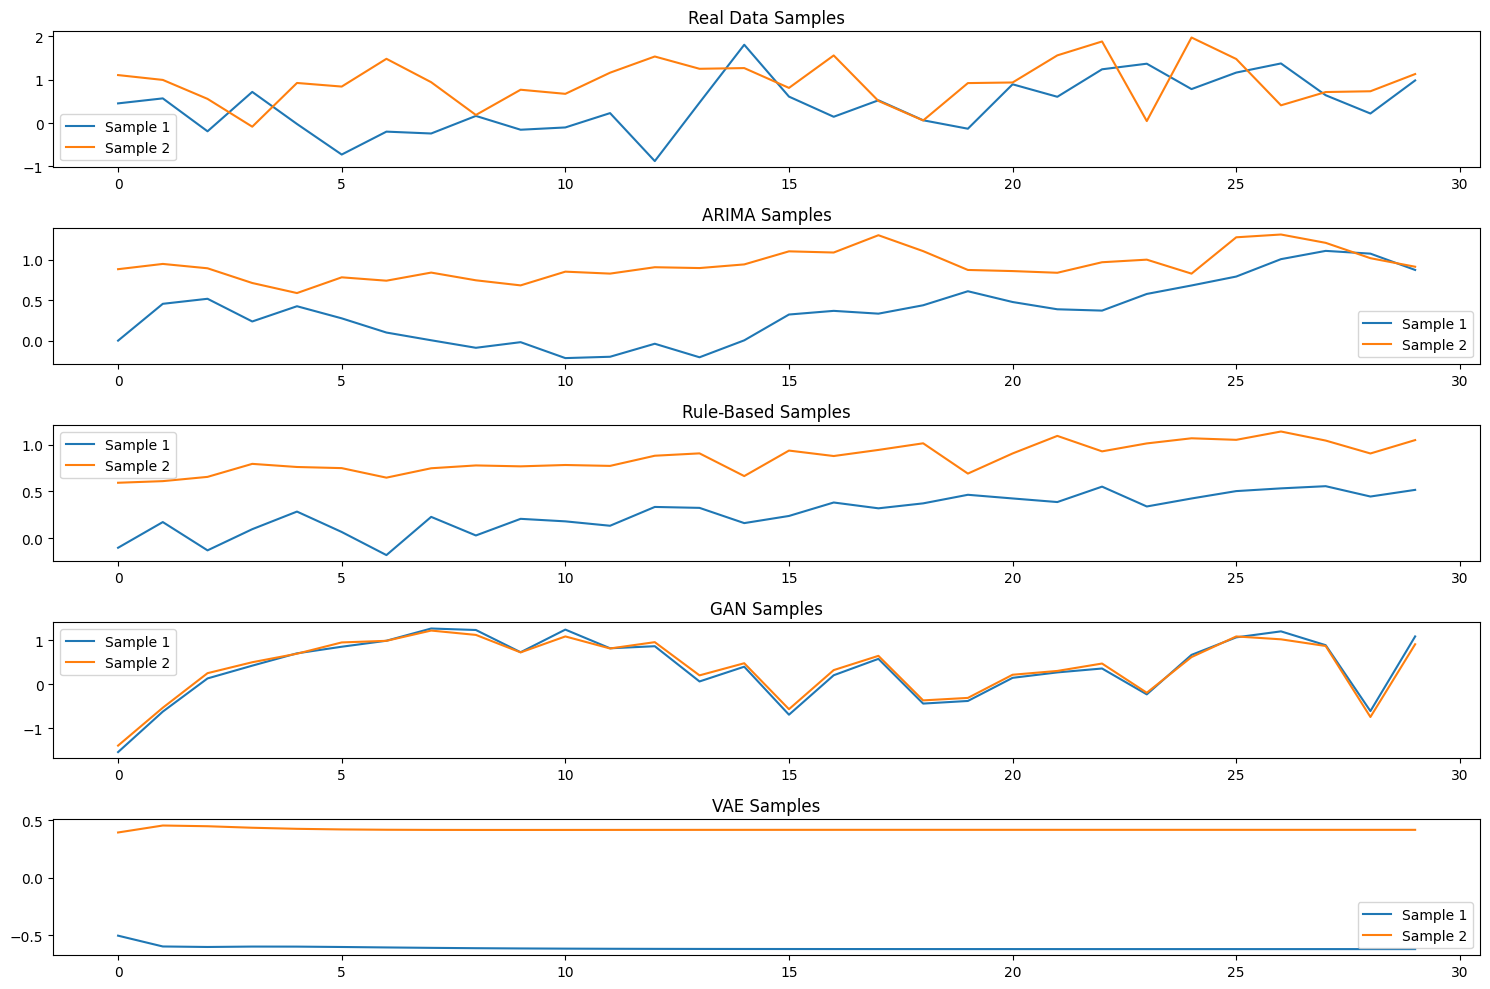

In [18]:
# Cell 6: Visualization and Comparison
plt.figure(figsize=(15, 10))

# Plot samples from each method
methods = {
    'Real Data': real_data,
    'ARIMA': arima_data,
    'Rule-Based': rule_based_data,
    'GAN': gan_data,
    'VAE': vae_data
}

for idx, (name, data) in enumerate(methods.items(), 1):
    plt.subplot(len(methods), 1, idx)
    plt.plot(data[0, :, 0], label='Sample 1')
    plt.plot(data[1, :, 0], label='Sample 2')
    plt.title(f'{name} Samples')
    plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Cell 7: Statistical Comparison
# Create comparison table
stats_table = []
for name, data in methods.items():
    method_stats = calculate_statistics(data)  # Avoid naming conflict
    autocorr = calculate_autocorrelation(data)
    method_stats['autocorrelation'] = autocorr
    method_stats['method'] = name
    stats_table.append(method_stats)

# Convert to DataFrame and display
comparison_df = pd.DataFrame(stats_table)
comparison_df = comparison_df.set_index('method')
print("\nStatistical Comparison:")
print(comparison_df.round(4))


Statistical Comparison:
              mean     std    skew  kurtosis  autocorrelation
method                                                       
Real Data  -0.0074  0.8616 -0.0529   -0.5751           0.6744
ARIMA      -0.0064  0.7296 -0.0231   -1.2468           0.9797
Rule-Based  5.0249  2.9590  0.0629   -1.0709           0.9988
GAN         0.4046  0.6572 -0.9215    0.2639           0.2796
VAE        -0.0477  0.6634  0.1740   -1.2985           0.9691


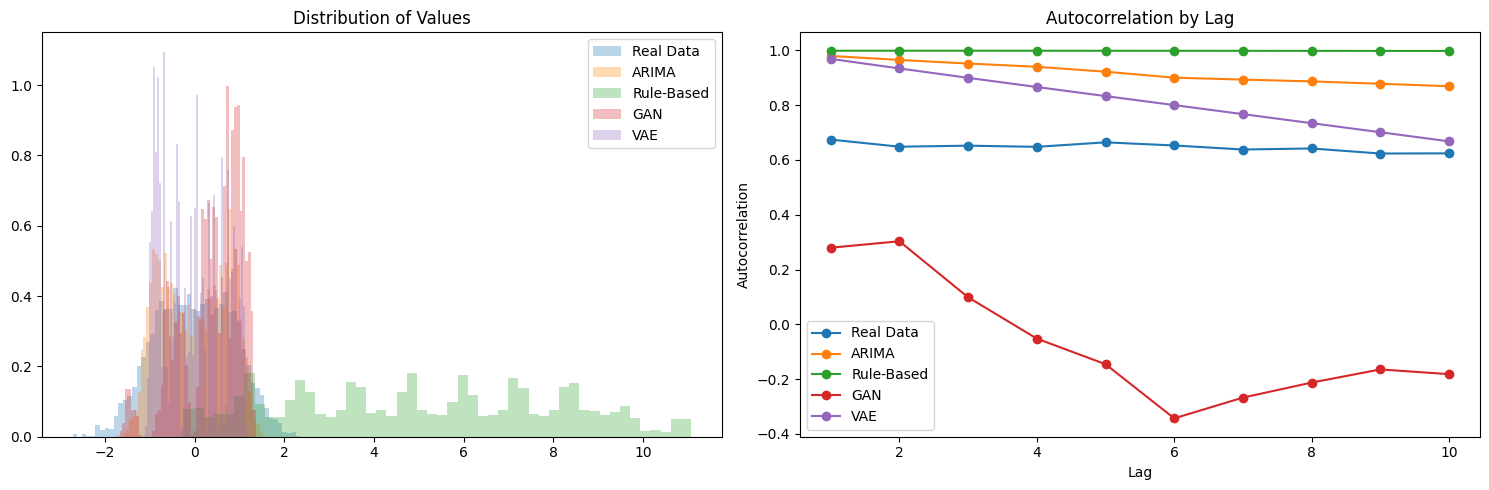

In [21]:
# Cell 8: Distribution Comparison
plt.figure(figsize=(15, 5))

# Plot distribution of values
plt.subplot(1, 2, 1)
for name, data in methods.items():
    plt.hist(data.flatten(), alpha=0.3, label=name, bins=50, density=True)
plt.title('Distribution of Values')
plt.legend()

# Plot autocorrelation comparison
plt.subplot(1, 2, 2)
lags = range(1, 11)
for name, data in methods.items():
    autocorrs = [calculate_autocorrelation(data, lag=l) for l in lags]
    plt.plot(lags, autocorrs, marker='o', label=name)
plt.title('Autocorrelation by Lag')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()

plt.tight_layout()
plt.show()